In [1]:
#Import packages
import pandas as pd
import numpy as np
import glob

from functions import plotting_raw_data, remove_outliers, error_plot, plot_cpt_data, plot_cpt_data_ML_prediction, plot_cpt_data_NW_site

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_param_importances, plot_optimization_history

c:\Users\haris\Documents\GitHub\ISGSR25_DataDrivenSiteCharacterization\DataDriven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
cm = 1/2.54  # centimeters in inches

In [3]:
data_ML = pd.read_csv('..\data\database_preprocessed_2025_soilparameter.csv')

In [4]:
prefix = r'..\graphics\\'
investigated_column =  ['gamma (kN/m3)', 'su (kPa)', 'M (MN/m2)', 'OCR (-)']
investigated_column_plot =  ['$\gamma$ (kN/m$^3$)', '$s_u$ (kPa)', 'M (MN/m$^2$)', 'OCR (-)']
save_paths = [prefix + '1_gamma_prediction.png', prefix + '2_su_prediction.png', prefix + '3_M_prediction.png']
axis_limit = [(13, 22), (0, 200), (0, 20), (0,20)]

j = 1
investigated_column_plot = investigated_column_plot[j]
investigated_column = investigated_column[j]
save_path = save_paths[j]

data_ML = data_ML.dropna(subset=[investigated_column])
print(f"{investigated_column} is selected to predict, {investigated_column_plot} is plotted, {save_path} is saved, {axis_limit[j]} is the axis limit, {len(data_ML)} is the length of the data")

#Remove the NGTS data from silt and clay test sites
data_ML_filtered = data_ML[~data_ML['sampling_name(-)'].str.contains(r'NGTS_Silt_|NGTS_Clay_', na=False)]

columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)'] #for plotting purpose

X = data_ML_filtered.loc[:,columns_x]
y = data_ML_filtered[investigated_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

su (kPa) is selected to predict, $s_u$ (kPa) is plotted, ..\graphics\\2_su_prediction.png is saved, (0, 200) is the axis limit, 222 is the length of the data


In [5]:
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
6,4.33,0.577517,5.333333,0.923494,365.750000,19.20,NaN,NaN,22.00,Norway_site
7,7.40,0.495280,2.380000,0.480536,409.940000,19.20,NaN,NaN,32.20,Norway_site
8,10.47,0.664800,3.733333,0.561572,530.166667,19.10,NaN,1.40,41.50,Norway_site
9,13.42,0.761940,6.080000,0.797963,551.700000,19.70,NaN,1.30,57.50,Norway_site
10,16.46,0.818240,5.680000,0.694173,636.740000,19.50,NaN,1.60,66.60,Norway_site
...,...,...,...,...,...,...,...,...,...,...
694,9.35,0.761000,17.000000,2.233903,389.000000,14.96,NaN,NaN,49.63,Koehool (70733_B3574 M013-a)
696,16.88,0.481000,7.000000,1.455301,231.000000,15.74,NaN,NaN,110.58,Koehool (70733_B3577 M009-a)
697,16.99,0.481000,7.000000,1.455301,231.000000,15.74,NaN,2.42,28.04,Koehool (70733_B3577 M009-a)
698,11.09,0.496000,7.000000,1.411290,264.000000,14.73,NaN,NaN,103.17,Koehool (70733_B3577 M013-a)


In [6]:
data_ML = data_ML_filtered
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
6,4.33,0.577517,5.333333,0.923494,365.750000,19.20,NaN,NaN,22.00,Norway_site
7,7.40,0.495280,2.380000,0.480536,409.940000,19.20,NaN,NaN,32.20,Norway_site
8,10.47,0.664800,3.733333,0.561572,530.166667,19.10,NaN,1.40,41.50,Norway_site
9,13.42,0.761940,6.080000,0.797963,551.700000,19.70,NaN,1.30,57.50,Norway_site
10,16.46,0.818240,5.680000,0.694173,636.740000,19.50,NaN,1.60,66.60,Norway_site
...,...,...,...,...,...,...,...,...,...,...
694,9.35,0.761000,17.000000,2.233903,389.000000,14.96,NaN,NaN,49.63,Koehool (70733_B3574 M013-a)
696,16.88,0.481000,7.000000,1.455301,231.000000,15.74,NaN,NaN,110.58,Koehool (70733_B3577 M009-a)
697,16.99,0.481000,7.000000,1.455301,231.000000,15.74,NaN,2.42,28.04,Koehool (70733_B3577 M009-a)
698,11.09,0.496000,7.000000,1.411290,264.000000,14.73,NaN,NaN,103.17,Koehool (70733_B3577 M013-a)


In [7]:
data_ML.describe()  # Descriptive statistics of the data

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa)
count,83.000000,83.000000,83.000000,83.000000,83.000000,82.000000,0.0,24.000000,83.000000
mean,9.035120,0.452817,10.516549,2.875586,281.775748,15.858732,NaN,1.511667,37.932892
std,5.626904,0.405333,6.152104,1.424502,263.482757,2.480452,NaN,0.286594,33.119253
min,1.640000,0.101000,2.000000,0.480536,-9.000000,11.590000,NaN,1.000000,5.500000
25%,5.090000,0.247111,7.000000,1.777295,108.500000,14.127500,NaN,1.385000,16.700000
50%,7.400000,0.316000,9.000000,2.965367,189.888889,14.960000,NaN,1.460000,24.700000
75%,11.190000,0.559915,13.340000,3.709048,388.210000,18.875000,NaN,1.650000,50.965000
max,24.430000,3.249000,41.025000,6.480955,1061.730000,20.500000,NaN,2.420000,200.000000


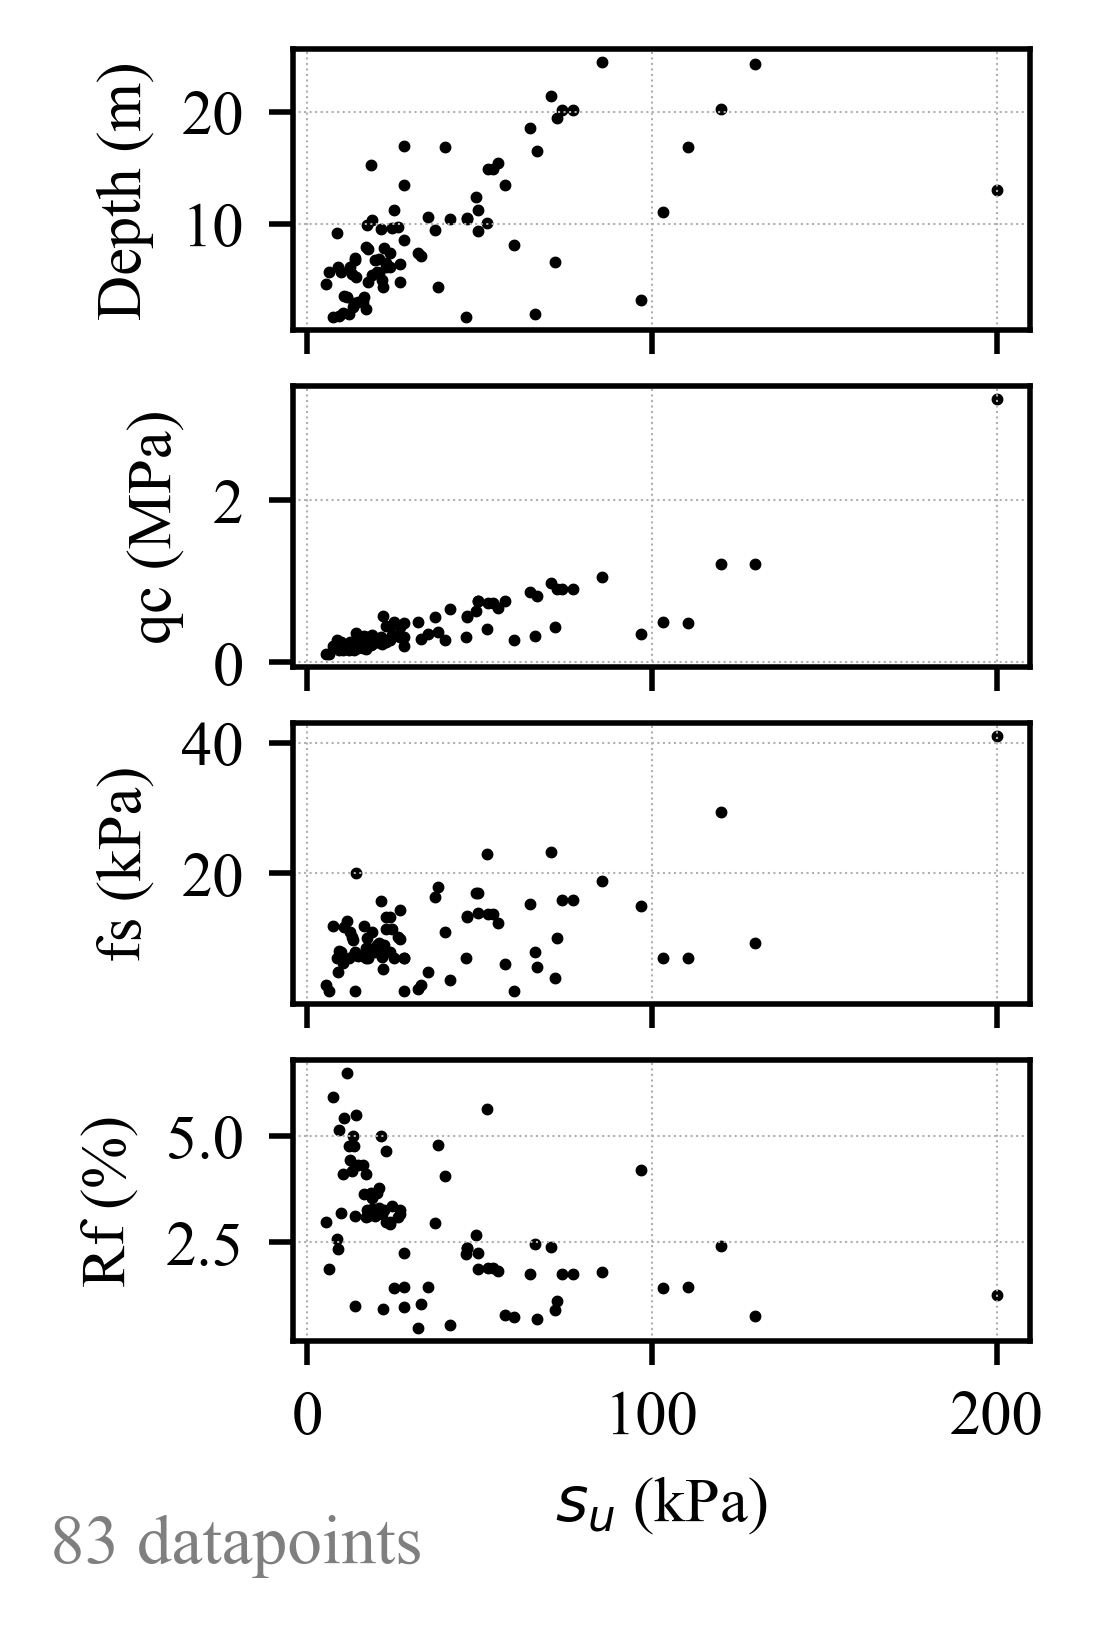

In [8]:
# Plotting training data 
s = 0.5  # Adjust the marker size as needed
color = 'k'  # Adjust the marker color as needed
alpha = 1

columns_x.append(investigated_column_plot)

#Plot scatter points: raw data points as
fig, axes = plt.subplots(4, 1, figsize=(15.4/3*cm, 8*cm), dpi=500, sharex=True)
plotting_raw_data(X,y, alpha, s, color, True, axes, columns_x, 'Raw data', False)

# Adjust layout to prevent overlapping
fig.text(0.01, 0.02, rf'{len(data_ML)} datapoints', ha='left', va='center', fontsize=10, color='black', alpha=0.5)
plt.subplots_adjust(left=0.25, right=0.98, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig(f"{prefix}{j+1}_raw_data.png", dpi = 1000)

In [9]:
RS = 44  # random state
N_JOBS = -1  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

# XGBoost
EARLY_STOPPING_ROUNDS = 10

In [ ]:
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS

from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination

class XGBRegressionProblem(Problem):
    def __init__(self, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RS, n_jobs=-1):
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.random_state = random_state
        self.n_jobs = n_jobs

        # Define bounds for hyperparameters
        bounds_lower = [50, 0.05, 3, 0.05, 0.01]
        bounds_upper = [120, 0.5, 10, 0.9, 2.0]

        super().__init__(n_var=5, n_obj=1, n_ieq_constr=0, xl=np.array(bounds_lower), xu=np.array(bounds_upper))

    def _evaluate(self, x, out, *args, **kwargs):
        results = []
        
        for params in x:
            n_estimators, learning_rate, max_depth, subsample, min_child_weight = params

            param = {
                "objective": "reg:squarederror",
                "tree_method": "hist",
                "n_estimators": int(n_estimators),
                "learning_rate": learning_rate,
                "max_depth": int(max_depth),
                "subsample": subsample,
                "min_child_weight": min_child_weight,
                "n_jobs": self.n_jobs,
            }

            model = xgb.XGBRegressor(**param, eval_metric="rmse", early_stopping_rounds = EARLY_STOPPING_ROUNDS)
            rkf = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.n_repeats, random_state=self.random_state)

            y_pred = np.zeros_like(self.y)

            for train_index, test_index in rkf.split(self.X):
                X_train, X_test = self.X[train_index, :], self.X[test_index, :]
                y_train, y_test = self.y[train_index], self.y[test_index]

                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
                y_pred[test_index] += model.predict(X_test)

            y_pred /= self.n_repeats
            r2 = r2_score(self.y, y_pred)
            
            results.append(-r2)

        out["F"] = np.array(results)


problem = XGBRegressionProblem(X_train, y_train)

algorithm = DE(
    pop_size=25,
    sampling=LHS(),
)

termination = DefaultSingleObjectiveTermination(ftol=1e-4, n_max_evals=1000)

res = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=1,
    save_history=True,
    verbose=True,
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       25 | -4.496414E-01 | -5.388601E-01
     2 |       50 | -4.774212E-01 | -6.293933E-01
     3 |       75 | -4.893528E-01 | -6.293933E-01
     4 |      100 | -5.193264E-01 | -6.639591E-01
     5 |      125 | -5.253923E-01 | -6.639591E-01
     6 |      150 | -5.346083E-01 | -6.639591E-01
     7 |      175 | -5.429284E-01 | -6.639591E-01
     8 |      200 | -5.482752E-01 | -6.639591E-01
     9 |      225 | -5.519095E-01 | -6.639591E-01
    10 |      250 | -5.575967E-01 | -6.639591E-01
    11 |      275 | -5.645733E-01 | -6.639591E-01
    12 |      300 | -5.723931E-01 | -6.639591E-01
    13 |      325 | -5.741026E-01 | -6.639591E-01
    14 |      350 | -5.809581E-01 | -6.639591E-01
    15 |      375 | -5.830842E-01 | -6.639591E-01
    16 |      400 | -5.833154E-01 | -6.639591E-01
    17 |      425 | -5.835248E-01 | -6.639591E-01
    18 |      450 | -5.835248E-01 | -6.639591E-01
    19 |      475 | -5.876663E-01 | -6.639591E-01


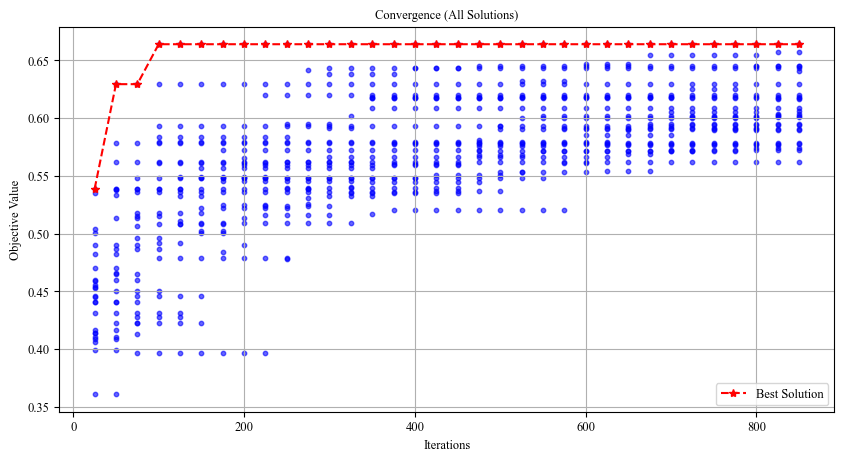

In [11]:
n_evals = []
all_opts = []

# Collect the evaluations and all objective values for each iteration
for e in res.history:
    n_evals.append(e.evaluator.n_eval)
    all_opts.append([sol.F for sol in e.pop])  # Collect all solutions' objectives

all_opts = np.array(all_opts)*(-1)


# Plotting
plt.figure(figsize=(10, 5))
# Plot each solution’s objective at each iteration
for i, opt_values in enumerate(all_opts):
    plt.scatter([n_evals[i]] * len(opt_values), opt_values, color='b', alpha=0.6, s=10)

# Plot the best solution per iteration
opt_best = np.array([e.opt[0].F for e in res.history]) * (-1)
plt.plot(n_evals, opt_best, "--*", color='r', label='Best Solution')

plt.title("Convergence (All Solutions)")
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.grid()
plt.legend()

In [12]:
# Extract the best parameters and objective value
best_params = {
    "n_estimators": int(res.X[0]),
    "learning_rate": res.X[1],
    "max_depth": int(res.X[2]),
    "subsample": res.X[3],
    "min_child_weight": res.X[4],
    "verbosity": 1,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_jobs": -1,  # Number of jobs
}

print("\nBest Parameters from DE Algorithm:")
for key, value in best_params.items():
    print(f"{key:>20s} : {value}")

best_r2 = -res.F[0]  # Convert back to positive R²
print(f"Best R²: {best_r2}")


Best Parameters from DE Algorithm:
        n_estimators : 87
       learning_rate : 0.40395104171762286
           max_depth : 9
           subsample : 0.15960471792956277
    min_child_weight : 0.7730007947764853
           verbosity : 1
           objective : reg:squarederror
         tree_method : hist
              n_jobs : -1
Best R²: 0.6639590907353754


In [13]:
model = xgb.XGBRegressor(**best_params, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
rkf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RS)
X_values = X_train.values
y_values = y_train.values
y_pred = np.zeros_like(y_test.values)
for train_index, test_index in rkf.split(X_values):
    X_A, X_B = X_values[train_index, :], X_values[test_index, :]
    y_A, y_B = y_values[train_index], y_values[test_index]
    model.fit(
        X_A,
        y_A,
        eval_set=[(X_B, y_B)],
        verbose=0,
    )
    y_pred += model.predict(X_test.values)
y_pred /= N_REPEATS * N_SPLITS

In [14]:
score, mse = r2_score(y_true=y_test, y_pred=y_pred), mean_squared_error(y_true=y_test, y_pred=y_pred)

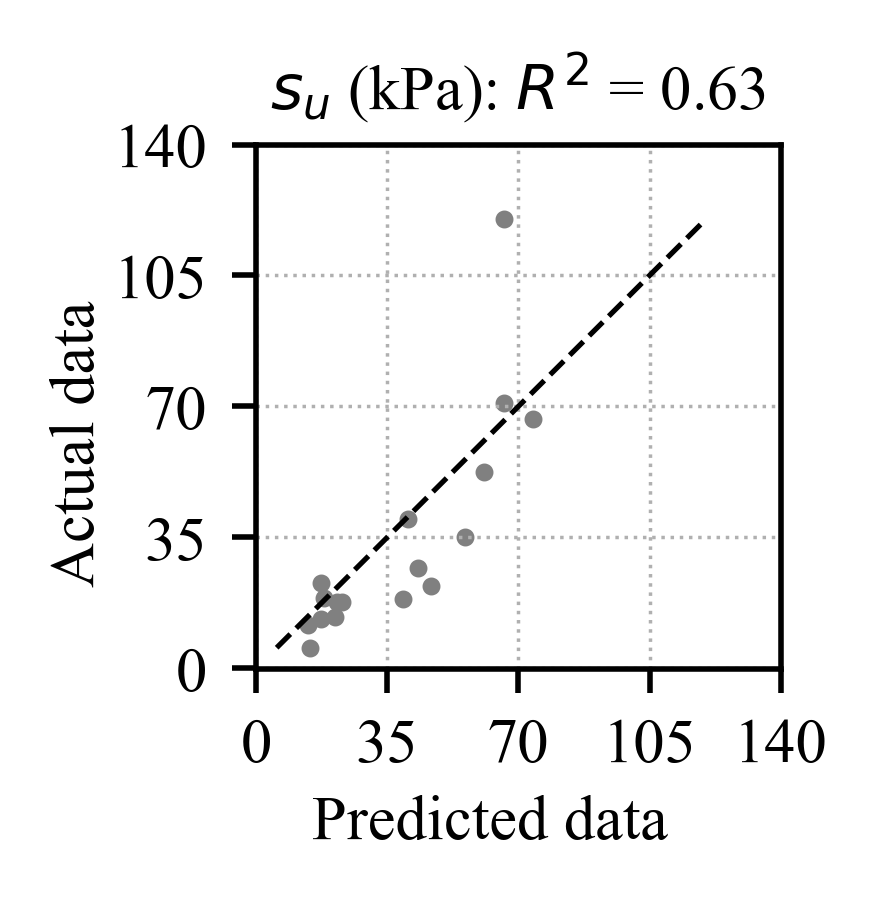

In [18]:
from sklearn.metrics import PredictionErrorDisplay

figsize= (15.4/3*cm, 15.4/3*cm)
l = 4.1 * cm
figsize= (l, l)
# figsize=(15.92/3*cm, 15.92/3*cm)


y_true = y_test
y_pred = pd.DataFrame(y_pred)


# Define plot structure
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=500)

ped = PredictionErrorDisplay.from_predictions(y_true=y_true,
                                            y_pred=y_pred,
                                            kind="actual_vs_predicted",
                                            subsample=100000,
                                            ax=axs,
                                            random_state=0, 
                                            line_kwargs={"color": "black", "linewidth": 0.75, "linestyle": "--", "alpha": 1},)

ped.ax_.set_xlabel("")  # Set x label
ped.ax_.set_ylabel("")  # Set y label

xlim, ylim = axis_limit[j][0], axis_limit[j][1]/2+40

ped.ax_.set_xticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
ped.ax_.set_yticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
ped.ax_.set_xlim(xlim)
# ped.ax_.set_ylim(xlim+0.001, ylim-0.001)


ped.ax_.grid(linewidth = 0.5, linestyle = 'dotted')

scatter = ped.figure_.axes[0].collections[0]
scatter.set_color('gray')  
scatter.set_sizes([2.5]) 
scatter.set_alpha([1]) 

# plt.title(f'{investigated_column_plot}: $R^2$ = {score:.2f}, $MSE$ = {mse:.2f}', x = 0.41, y=1.02)
plt.title(f'{investigated_column_plot}: $R^2$ = {score:.2f}', x = 0.5, y=0.99)

ax = ped.ax_
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', rotation=0)

fig.text(0.55, 0.03, r'Predicted data', ha='center', va='center')
fig.text(0.04, 0.5, r'Actual data', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=0.26, right=0.91, top=0.87, bottom=0.22, wspace=0.5, hspace=0.5)
plt.savefig(save_path, dpi=1000)

In [16]:
# Save the model using joblib or pickle
import joblib

# Fit the model on the entire dataset with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params, eval_metric="rmse", random_state=RS)

# Fit the model on the entire dataset
final_model.fit(X, y)

name = save_path.split('\\')[-1].split('.')[0]
joblib.dump(final_model, f'{name}_xgb_model.joblib')


['2_su_prediction_xgb_model.joblib']